<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/master/cca_zoo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install cca-zoo --upgrade
!pip install scipy --upgrade

Requirement already up-to-date: cca-zoo in /usr/local/lib/python3.6/dist-packages (1.1.14)
     |████████████████████████████████| 25.9MB 158kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [9]:
# Imports
import numpy as np
from cca_zoo import wrappers
from cca_zoo import data
import itertools
import os
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch import optim

# Load MNIST Data
os.chdir('..')
N = 500
dataset = data.Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=True)
ids = np.arange(min(2 * N, len(dataset)))
np.random.shuffle(ids)
train_ids, val_ids = np.array_split(ids, 2)
val_dataset = Subset(dataset, val_ids)
train_dataset = Subset(dataset, train_ids)
test_dataset = data.Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=False)
test_ids = np.arange(min(N, len(test_dataset)))
np.random.shuffle(test_ids)
test_dataset = Subset(test_dataset, test_ids)
train_view_1, train_view_2, train_rotations, train_OH_labels, train_labels = train_dataset.dataset.to_numpy(
    train_dataset.indices)
val_view_1, val_view_2, val_rotations, val_OH_labels, val_labels = val_dataset.dataset.to_numpy(val_dataset.indices)
test_view_1, test_view_2, test_rotations, test_OH_labels, test_labels = test_dataset.dataset.to_numpy(
    test_dataset.indices)

# Settings

# The number of latent dimensions across models
latent_dims = 2
# The number of folds used for cross-validation/hyperparameter tuning
cv_folds = 5
# For running hyperparameter tuning in parallel (0 if not)
jobs = 2
# Number of iterations for iterative algorithms
max_iter = 2
# number of epochs for deep models
epochs = 50

# Canonical Correlation Analysis

In [2]:
"""
### Linear CCA via alternating least squares (can pass more than 2 views)
"""
linear_cca = wrappers.CCA(latent_dims=latent_dims, max_iter=max_iter)

linear_cca.fit(train_view_1, train_view_2)

linear_cca_results = np.stack(
    (linear_cca.train_correlations[0, 1], linear_cca.predict_corr(test_view_1, test_view_2)[0, 1]))

# Partial Least Squares


In [3]:
"""
### PLS with scikit-learn (only permits 2 views)
"""
pls = wrappers.PLS(latent_dims=latent_dims)

pls.fit(train_view_1, train_view_2)

pls_results = np.stack(
    (pls.train_correlations[0, 1], pls.predict_corr(test_view_1, test_view_2)[0, 1]))

# Extension to multiple views



In [4]:
"""
### (Regularized) Generalized CCA(can pass more than 2 views)
"""

gcca = wrappers.GCCA(latent_dims=latent_dims)

# small ammount of regularisation added since data is not full rank
c=[0.5,0.5,0.5]

gcca.fit(train_view_1, train_view_2,train_view_1, c=c)

gcca_results = np.stack((gcca.train_correlations[0, 1], gcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### (Regularized) Multiset CCA(can pass more than 2 views)
"""

mcca = wrappers.MCCA(latent_dims=latent_dims)

mcca.fit(train_view_1, train_view_2,train_view_1, c=c)

mcca_results = np.stack((mcca.train_correlations[0, 1], mcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Multiset CCA by alternating least squares
"""
mcca_als = wrappers.CCA(latent_dims=latent_dims, max_iter=max_iter)

mcca_als.fit(train_view_1, train_view_2,train_view_1)

mcca_als_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_als.predict_corr(test_view_1, test_view_2)[0, 1]))

c=[1,1,1]

"""
### Multiset PLS by alternating least squares
"""
mcca_pls = wrappers.PLS(latent_dims=latent_dims, max_iter=max_iter)

mcca_pls.fit(train_view_1, train_view_2,train_view_1)

mcca_pls_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_pls.predict_corr(test_view_1, test_view_2)[0, 1]))

# Rgularised CCA solutions based on alternating minimisation/alternating least squares

We implement Witten's penalized matrix decomposition form of sparse CCA using 'pmd'

We implement Waaijenborg's penalized CCA using elastic net using 'elastic'

We implement Mai's sparse CCA using 'scca'

Furthermore, any of these methods can be extended to multiple views. Witten describes this method explicitly.

cross validation
number of folds:  5
Best score :  1.2899844289918008
Standard deviation :  0.07622474332093118
{'c': (9, 9)}
cross validation
number of folds:  5
Best score :  0.9219321872474866
Standard deviation :  0.05129687846684718
{'c': (0.0001, 1e-05)}
cross validation
number of folds:  5
Best score :  1.0101161218638939
Standard deviation :  0.09273538138398763
{'c': (0.001, 0.0001), 'l1_ratio': (0.1, 0.01)}


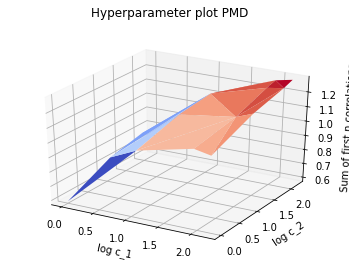

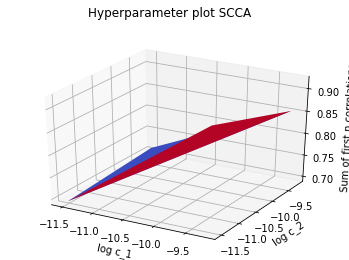

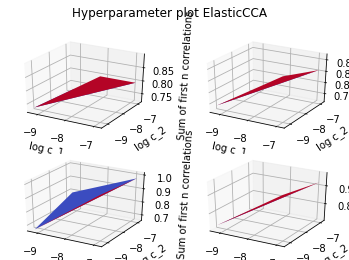

In [5]:
"""
### Sparse CCA (Penalized Matrix Decomposition) (can pass more than 2 views)
"""

# PMD
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_candidates = {'c': list(itertools.product(c1, c2))}

pmd = wrappers.PMD(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

pmd_results = np.stack((pmd.train_correlations[0, 1, :], pmd.predict_corr(test_view_1, test_view_2)[0, 1, :]))

"""
### Sparse CCA (can pass more than 2 views)
"""

# Sparse CCA
c1 = [0.00001, 0.0001]
c2 = [0.00001, 0.0001]
param_candidates = {'c': list(itertools.product(c1, c2))}

scca = wrappers.SCCA(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True,
    jobs=jobs, plot=True)

scca_results = np.stack(
    (scca.train_correlations[0, 1, :], scca.predict_corr(test_view_1, test_view_2)[0, 1, :]))


"""
### Elastic CCA (can pass more than 2 views)
"""

# Elastic CCA
c1 = [0.001, 0.0001]
c2 = [0.001, 0.0001]
l1_1 = [0.01, 0.1]
l1_2 = [0.01, 0.1]
param_candidates = {'c': list(itertools.product(c1, c2)), 'l1_ratio': list(itertools.product(l1_1, l1_2))}

elastic = wrappers.ElasticCCA(latent_dims=latent_dims,
                              max_iter=max_iter).gridsearch_fit(train_view_1,
                                                                train_view_2,
                                                                param_candidates=param_candidates,
                                                                folds=cv_folds,
                                                                verbose=True,
                                                                jobs=jobs,
                                                                plot=True)

elastic_results = np.stack(
    (elastic.train_correlations[0, 1, :], elastic.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Kernel CCA

cross validation
number of folds:  5
Best score :  1.5027153351321079
Standard deviation :  0.05566014092748785
{'kernel': 'linear', 'c': (0.99, 0.99)}
cross validation
number of folds:  5
Best score :  1.1000282402945978
Standard deviation :  0.12897650918531878
{'kernel': 'poly', 'degree': 3, 'c': (0.9, 0.9)}
cross validation
number of folds:  5
Best score :  1.2647731564787041
Standard deviation :  0.06503382247430843
{'kernel': 'rbf', 'sigma': 100.0, 'c': (0.99, 0.9)}


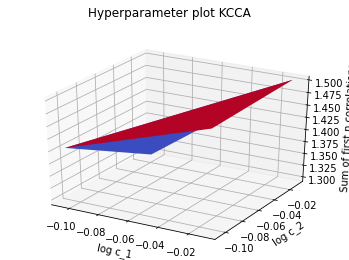

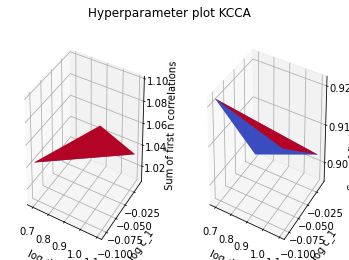

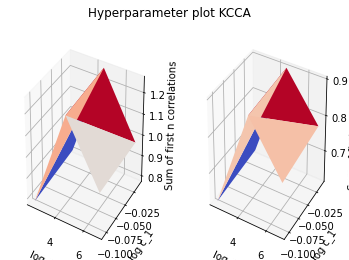

In [6]:
"""
### Kernel CCA

Similarly, we can use kernel CCA methods with [method='kernel']

We can use different kernels and their associated parameters in a similar manner to before
- regularized linear kernel CCA: parameters :  'kernel'='linear', 0<'c'<1
- polynomial kernel CCA: parameters : 'kernel'='poly', 'degree', 0<'c'<1
- gaussian rbf kernel CCA: parameters : 'kernel'='gaussian', 'sigma', 0<'c'<1
"""
# %%
# r-kernel cca
c1 = [0.9, 0.99]
c2 = [0.9, 0.99]

param_candidates = {'kernel': ['linear'], 'c': list(itertools.product(c1, c2))}

kernel_reg = wrappers.KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                                   folds=cv_folds,
                                                                   param_candidates=param_candidates,
                                                                   verbose=True, jobs=jobs,
                                                                   plot=True)
kernel_reg_results = np.stack((
    kernel_reg.train_correlations[0, 1, :],
    kernel_reg.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (poly)
param_candidates = {'kernel': ['poly'], 'degree': [2, 3], 'c': list(itertools.product(c1, c2))}

kernel_poly = wrappers.KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                                    folds=cv_folds,
                                                                    param_candidates=param_candidates,
                                                                    verbose=True, jobs=jobs,
                                                                    plot=True)

kernel_poly_results = np.stack((
    kernel_poly.train_correlations[0, 1, :],
    kernel_poly.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (gaussian)
param_candidates = {'kernel': ['rbf'], 'sigma': [1e+1, 1e+2, 1e+3], 'c': list(itertools.product(c1, c2))}

kernel_gaussian = wrappers.KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                                        folds=cv_folds,
                                                                        param_candidates=param_candidates,
                                                                        verbose=True, jobs=jobs,
                                                                        plot=True)

kernel_gaussian_results = np.stack((
    kernel_gaussian.train_correlations[0, 1, :],
    kernel_gaussian.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Deep CCA

DCCA can be optimized using Andrew's original tracenorm objective or Wang's DCCA by nonlinear orthogonal iterations using the argument als=True.

DCCA
total parameters:  201476


/usr/local/lib/python3.6/dist-packages/cca_zoo/objectives.py:14: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  posInd1 = torch.gt(D, eps).nonzero()[:, 0]


====> Epoch: 1 Average train loss: -0.4431
====> Epoch: 1 Average val loss: -1.0643
Min loss -1.06
====> Epoch: 2 Average train loss: -1.1220
====> Epoch: 2 Average val loss: -1.1941
Min loss -1.19
====> Epoch: 3 Average train loss: -1.2554
====> Epoch: 3 Average val loss: -1.2844
Min loss -1.28
====> Epoch: 4 Average train loss: -1.3055
====> Epoch: 4 Average val loss: -1.3334
Min loss -1.33
====> Epoch: 5 Average train loss: -1.3509
====> Epoch: 5 Average val loss: -1.3255
====> Epoch: 6 Average train loss: -1.3450
====> Epoch: 6 Average val loss: -1.4067
Min loss -1.41
====> Epoch: 7 Average train loss: -1.3697
====> Epoch: 7 Average val loss: -1.3414
====> Epoch: 8 Average train loss: -1.3583
====> Epoch: 8 Average val loss: -1.3813
====> Epoch: 9 Average train loss: -1.4205
====> Epoch: 9 Average val loss: -1.3809
====> Epoch: 10 Average train loss: -1.3794
====> Epoch: 10 Average val loss: -1.4137
Min loss -1.41
====> Epoch: 11 Average train loss: -1.4012
====> Epoch: 11 Average 

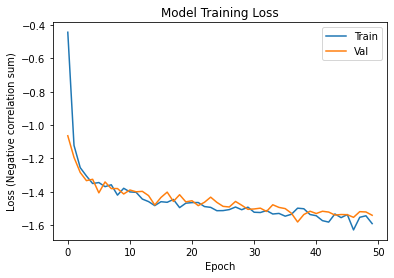

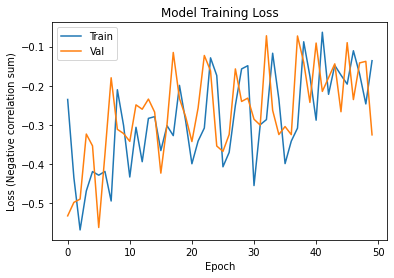

In [7]:
"""
### Deep Learning

We also have deep CCA methods (and autoencoder variants)
- Deep CCA (DCCA)
- Deep Canonically Correlated Autoencoders (DCCAE)

We introduce a Config class from configuration.py. This contains a number of default settings for running DCCA.

"""
from cca_zoo import deepwrapper, objectives, dcca, deep_models

# %%
# DCCA
print('DCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_model = deepwrapper.DeepWrapper(dcca_model)

dcca_model.fit(train_dataset, val_dataset, epochs=epochs)

dcca_results = np.stack((dcca_model.train_correlations[0, 1], dcca_model.predict_corr(test_view_1, test_view_2)[0, 1]))


# DCCA_NOI
# Note that als=True
print('DCCA by non-linear orthogonal iterations')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_noi_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], als=True)

dcca_noi_model = deepwrapper.DeepWrapper(dcca_noi_model)

dcca_noi_model.fit(train_dataset, val_dataset, epochs=epochs)

dcca_noi_results = np.stack(
    (dcca_noi_model.train_correlations[0, 1], dcca_noi_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# DCCA with custom optimizers and schedulers

total parameters:  201476
====> Epoch: 1 Average train loss: -0.1977
====> Epoch: 1 Average val loss: -0.4202
Min loss -0.42
====> Epoch: 2 Average train loss: -0.3193
====> Epoch: 2 Average val loss: -0.4494
Min loss -0.45
====> Epoch: 3 Average train loss: -0.4959
====> Epoch: 3 Average val loss: -0.5511
Min loss -0.55
====> Epoch: 4 Average train loss: -0.4976
====> Epoch: 4 Average val loss: -0.6216
Min loss -0.62
====> Epoch: 5 Average train loss: -0.6210
====> Epoch: 5 Average val loss: -0.7720
Min loss -0.77
====> Epoch: 6 Average train loss: -0.7701
====> Epoch: 6 Average val loss: -0.7251
====> Epoch: 7 Average train loss: -0.8746
====> Epoch: 7 Average val loss: -0.8668
Min loss -0.87
====> Epoch: 8 Average train loss: -0.8126
====> Epoch: 8 Average val loss: -0.9369
Min loss -0.94
====> Epoch: 9 Average train loss: -0.8158
====> Epoch: 9 Average val loss: -1.0307
Min loss -1.03
====> Epoch: 10 Average train loss: -0.9973
====> Epoch: 10 Average val loss: -1.0372
Min loss -1.

DeepWrapper(device='cpu',
            model=DCCA(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=128, out_features=2, bias=True)
        )
      )
    )
    (1): Encoder(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=128, out_features=2, bias=True)
        )
      )
    )
  )
))

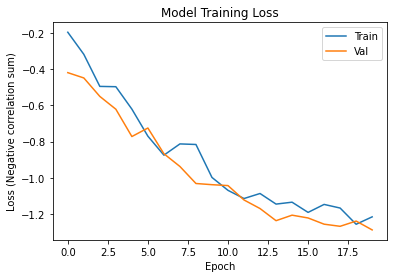

In [14]:
# DCCA
optimizers = [optim.Adam(encoder_1.parameters(), lr=1e-4), optim.Adam(encoder_2.parameters(), lr=1e-4)]
schedulers = [optim.lr_scheduler.CosineAnnealingLR(optimizers[0], 1),
              optim.lr_scheduler.ReduceLROnPlateau(optimizers[1])]
dcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],
                                objective=objectives.CCA, optimizers=optimizers, schedulers=schedulers)
# hidden_layer_sizes are shown explicitly but these are also the defaults
dcca_model = deepwrapper.DeepWrapper(dcca_model)
dcca_model.fit(train_dataset, val_dataset,epochs=20)

# DGCCA and DMCCA for more than 2 views

The only change we need to make is to the objective argument to perform DGCCA and DMCCA.

DGCCA
total parameters:  201476
====> Epoch: 1 Average train loss: -0.1239
====> Epoch: 1 Average val loss: -0.9664
Min loss -0.97
====> Epoch: 2 Average train loss: -0.8411
====> Epoch: 2 Average val loss: -1.1609
Min loss -1.16
====> Epoch: 3 Average train loss: -1.2010
====> Epoch: 3 Average val loss: -1.2933
Min loss -1.29
====> Epoch: 4 Average train loss: -1.2765
====> Epoch: 4 Average val loss: -1.3982
Min loss -1.40
====> Epoch: 5 Average train loss: -1.2740
====> Epoch: 5 Average val loss: -1.3050
====> Epoch: 6 Average train loss: -1.3421
====> Epoch: 6 Average val loss: -1.3619
====> Epoch: 7 Average train loss: -1.3455
====> Epoch: 7 Average val loss: -1.3875
====> Epoch: 8 Average train loss: -1.3239
====> Epoch: 8 Average val loss: -1.3758
====> Epoch: 9 Average train loss: -1.3181
====> Epoch: 9 Average val loss: -1.4103
Min loss -1.41
====> Epoch: 10 Average train loss: -1.3494
====> Epoch: 10 Average val loss: -1.4303
Min loss -1.43
====> Epoch: 11 Average train loss: 

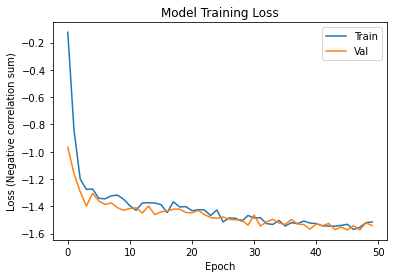

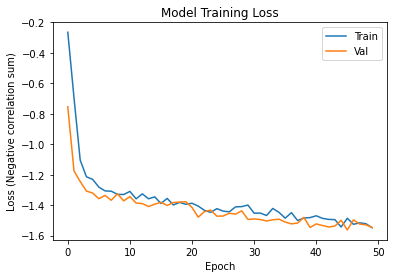

In [15]:
# DGCCA
print('DGCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dgcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.GCCA)

dgcca_model = deepwrapper.DeepWrapper(dgcca_model)

dgcca_model.fit(train_dataset, val_dataset, epochs=epochs)

dgcca_results = np.stack(
    (dgcca_model.train_correlations[0, 1], dgcca_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# DMCCA
print('DMCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
dmcca_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.MCCA)

dmcca_model = deepwrapper.DeepWrapper(dmcca_model)

dmcca_model.fit(train_dataset, val_dataset, epochs=epochs)

dmcca_results = np.stack(
    (dmcca_model.train_correlations[0, 1], dmcca_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# Deep Canonically Correlated Autoencoders
We need to add decoders in order to model deep canonically correlated autoencoders and we also use the DCCAE class which inherits from DCCA

DCCAE
total parameters:  404516
====> Epoch: 1 Average train loss: 90382.3281
====> Epoch: 1 Average val loss: 79508.1484
Min loss 79508.15
====> Epoch: 2 Average train loss: 78480.2812
====> Epoch: 2 Average val loss: 68363.5703
Min loss 68363.57
====> Epoch: 3 Average train loss: 67479.7969
====> Epoch: 3 Average val loss: 58455.6055
Min loss 58455.61
====> Epoch: 4 Average train loss: 57711.5156
====> Epoch: 4 Average val loss: 50619.7148
Min loss 50619.71
====> Epoch: 5 Average train loss: 49990.6250
====> Epoch: 5 Average val loss: 44074.8789
Min loss 44074.88
====> Epoch: 6 Average train loss: 43557.7500
====> Epoch: 6 Average val loss: 38175.9648
Min loss 38175.96
====> Epoch: 7 Average train loss: 37778.6914
====> Epoch: 7 Average val loss: 33537.3594
Min loss 33537.36
====> Epoch: 8 Average train loss: 33245.5000
====> Epoch: 8 Average val loss: 30013.3398
Min loss 30013.34
====> Epoch: 9 Average train loss: 29809.2324
====> Epoch: 9 Average val loss: 27107.8125
Min loss 27107

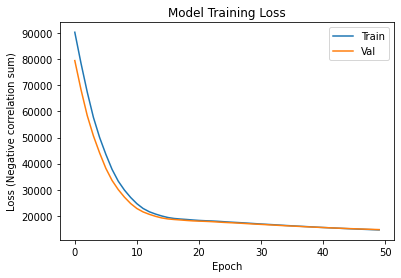

In [21]:
from cca_zoo import dccae

# DCCAE
print('DCCAE')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784)
dccae_model = dccae.DCCAE(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])

dccae_model = deepwrapper.DeepWrapper(dccae_model)

dccae_model.fit(train_view_1, train_view_2, epochs=epochs)

dccae_results = np.stack(
    (dccae_model.train_correlations[0, 1], dccae_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# Deep Variational CCA

DVCCA
total parameters:  405548
====> Epoch: 1 Average train loss: 1106.4146
====> Epoch: 1 Average val loss: 1086.5638
Min loss 1086.56
====> Epoch: 2 Average train loss: 1087.0239
====> Epoch: 2 Average val loss: 1064.5892
Min loss 1064.59
====> Epoch: 3 Average train loss: 1064.6431
====> Epoch: 3 Average val loss: 1047.3743
Min loss 1047.37
====> Epoch: 4 Average train loss: 1046.4243
====> Epoch: 4 Average val loss: 1030.2651
Min loss 1030.27
====> Epoch: 5 Average train loss: 1030.1860
====> Epoch: 5 Average val loss: 1013.1198
Min loss 1013.12
====> Epoch: 6 Average train loss: 1012.5192
====> Epoch: 6 Average val loss: 997.9464
Min loss 997.95
====> Epoch: 7 Average train loss: 999.0942
====> Epoch: 7 Average val loss: 985.1146
Min loss 985.11
====> Epoch: 8 Average train loss: 985.1987
====> Epoch: 8 Average val loss: 974.3577
Min loss 974.36
====> Epoch: 9 Average train loss: 972.7303
====> Epoch: 9 Average val loss: 961.1241
Min loss 961.12
====> Epoch: 10 Average train loss

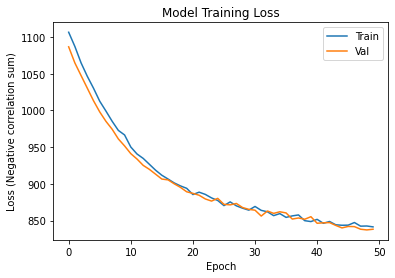

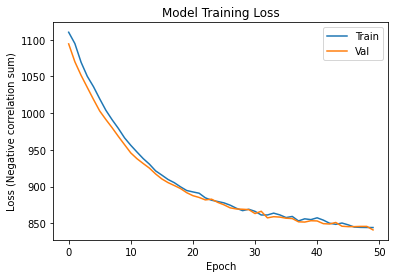

In [18]:
"""
### Deep Variational Learning
Finally we have Deep Variational CCA methods.
- Deep Variational CCA (DVCCA)
- Deep Variational CCA - private (DVVCA_p)

These are both implemented by the DVCCA class with private=True/False and both_encoders=True/False. If both_encoders,
the encoder to the shared information Q(z_shared|x) is modelled for both x_1 and x_2 whereas if both_encoders is false
it is modelled for x_1 as in the paper
"""
from cca_zoo import dvcca

# %%
# DVCCA (technically bi-DVCCA)
print('DVCCA')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
dvcca_model = dvcca.DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                          private=False)

dvcca_model = deepwrapper.DeepWrapper(dvcca_model)

dvcca_model.fit(train_dataset, val_dataset, epochs=epochs)

dvcca_model_results = np.stack(
    (dvcca_model.train_correlations[0, 1], dvcca_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# DVCCA_private (technically bi-DVCCA_private)
print('DVCCA_private')
encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_1 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_2 = deep_models.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
decoder_1 = deep_models.Decoder(latent_dims=latent_dims * 3, feature_size=784, norm_output=True)
decoder_2 = deep_models.Decoder(latent_dims=latent_dims * 3, feature_size=784, norm_output=True)
dvccap_model = dvcca.DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                           private_encoders=[private_encoder_1, private_encoder_2], private=True)

dvccap_model = deepwrapper.DeepWrapper(dvccap_model)

dvccap_model.fit(train_dataset, val_dataset, epochs=epochs)

dvccap_model_results = np.stack(
    (dvccap_model.train_correlations[0, 1], dvccap_model.predict_corr(test_view_1, test_view_2)[0, 1]))

# Convolutional Deep CCA (and using other architectures)
We provide a standard CNN encoder and decoder but users can build their own encoders and decoders by inheriting BaseEncoder and BaseDecoder for seamless integration with the pipeline

Convolutional DCCA
total parameters:  2512
====> Epoch: 1 Average train loss: -0.0607
====> Epoch: 1 Average val loss: -0.1908
Min loss -0.19
====> Epoch: 2 Average train loss: -0.3223
====> Epoch: 2 Average val loss: -0.3132
Min loss -0.31
====> Epoch: 3 Average train loss: -0.5265
====> Epoch: 3 Average val loss: -0.4146
Min loss -0.41
====> Epoch: 4 Average train loss: -0.7103
====> Epoch: 4 Average val loss: -0.5259
Min loss -0.53
====> Epoch: 5 Average train loss: -0.8838
====> Epoch: 5 Average val loss: -0.6421
Min loss -0.64
====> Epoch: 6 Average train loss: -1.0266
====> Epoch: 6 Average val loss: -0.7511
Min loss -0.75
====> Epoch: 7 Average train loss: -1.1353
====> Epoch: 7 Average val loss: -0.8482
Min loss -0.85
====> Epoch: 8 Average train loss: -1.2263
====> Epoch: 8 Average val loss: -0.9327
Min loss -0.93
====> Epoch: 9 Average train loss: -1.3057
====> Epoch: 9 Average val loss: -1.0028
Min loss -1.00
====> Epoch: 10 Average train loss: -1.3738
====> Epoch: 10 Averag

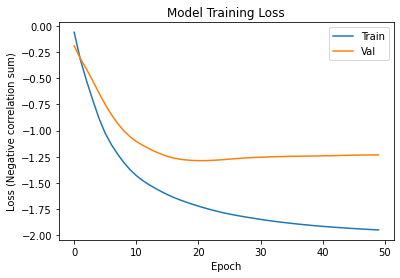

In [19]:
print('Convolutional DCCA')
encoder_1 = deep_models.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
encoder_2 = deep_models.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
dcca_conv_model = dcca.DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])

dcca_conv_model = deepwrapper.DeepWrapper(dcca_conv_model)

# to change the models used change the cfg.encoder_models. We implement a CNN_Encoder and CNN_decoder as well
# as some based on brainnet architecture in cca_zoo.deep_models. Equally you could pass your own encoder/decoder models

dcca_conv_model.fit(train_view_1.reshape((-1, 1, 28, 28)), train_view_2.reshape((-1, 1, 28, 28)), epochs=epochs)

dcca_conv_results = np.stack(
    (dcca_conv_model.train_correlations[0, 1], dcca_conv_model.predict_corr(test_view_1.reshape((-1, 1, 28, 28)),
                                                                            test_view_2.reshape(
                                                                                (-1, 1, 28, 28)))[0, 1]))

# Generate Some Plots

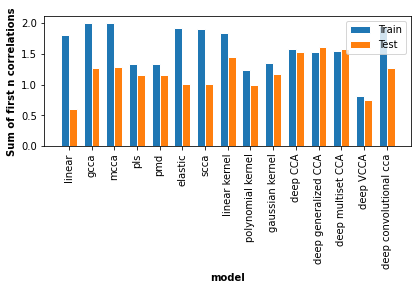

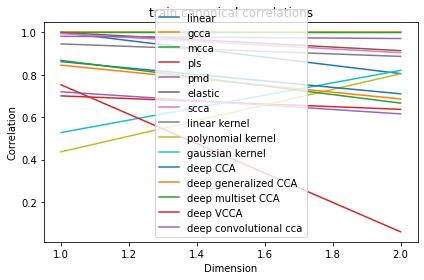

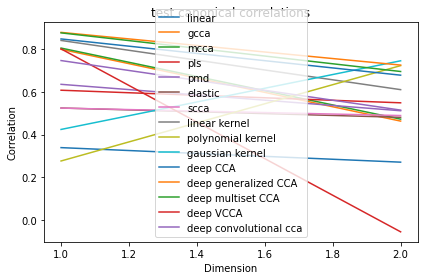

In [20]:
"""
### Make results plot to compare methods
"""
# %%

all_results = np.stack(
    [linear_cca_results, gcca_results, mcca_results, pls_results, pmd_results, elastic_results,
     scca_results, kernel_reg_results, kernel_poly_results,
     kernel_gaussian_results, dcca_results, dgcca_results, dmcca_results, dvcca_model_results,
     dcca_conv_results],
    axis=0)
all_labels = ['linear', 'gcca', 'mcca', 'pls', 'pmd', 'elastic', 'scca', 'linear kernel', 'polynomial kernel',
              'gaussian kernel', 'deep CCA', 'deep generalized CCA', 'deep multiset CCA', 'deep VCCA',
              'deep convolutional cca']

from cca_zoo import plot_utils

plot_utils.plot_results(all_results, all_labels)
plt.show()